<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


### Импортируем библиотеки

In [ ]:
import os

import skimage.io
from skimage.transform import resize
import pickle

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import DataLoader
# from torch.autograd import Variable
from torchvision import datasets, transforms

from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
!pip freeze > requirements.txt 

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id): # передается в параметр DataLoader(...worker_init_fn=seed_worker)
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(2147483647)

In [ ]:
DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Thu May 27 08:04:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

Будем сохранять лучшие модели

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/DLS_MFTI/DLS_adv/W8_autoencoders/hw_autoencoders/'

### Загружаем данные

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
# Посмотрим, как выглядит таблица атрибутов изображений
attrs.head(6)

Male     Asian  ... Wearing Necktie Wearing Necklace
0   1.56835  -1.88904  ...        0.694007        -0.826609
1  0.169851 -0.982408  ...         0.66676        -0.496559
2  0.997749  -1.36419  ...        0.144262        -0.841231
3   1.12272   -1.9978  ...        0.475941        -0.447025
4   1.07821   -2.0081  ...       -0.760774        -0.410152
5  0.850491  -1.48208  ...        0.886694        -0.154051

[6 rows x 73 columns]


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, 
                                                                    shuffle=True, 
                                                                    random_state=1)
train_loader = DataLoader(np.rollaxis(train_photos, 3, 1), batch_size=128, shuffle=True, worker_init_fn=seed_worker)
val_loader = DataLoader(np.rollaxis(val_photos, 3, 1), batch_size=128)

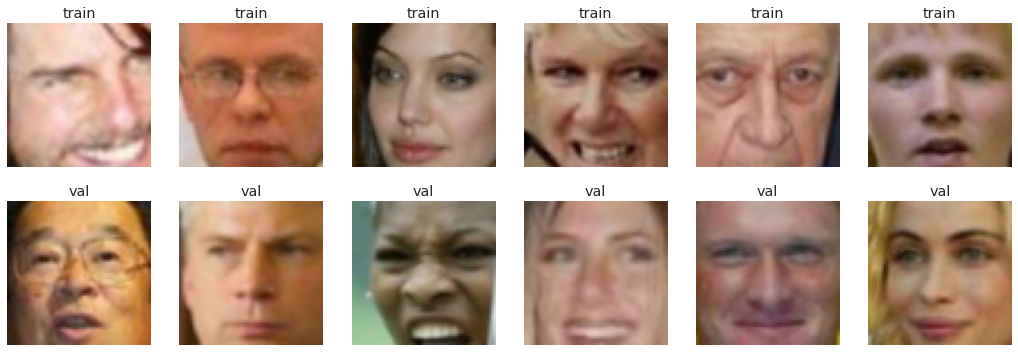

In [ ]:
x_train = next(iter(train_loader)).numpy()
x_val = next(iter(val_loader)).numpy()

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_train[i], 0, 3))
    plt.title('train')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val[i], 0, 3))
    plt.title('val')

plt.show();

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
# ae3
# from copy import deepcopy
dim_code = 128

class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()

      self.encoder = nn.Sequential(
            # s1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding = 1, padding_mode='replicate'),
            nn.ReLU(),
            
            # s2 64 -> 30
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, dilation=2, padding = 2, padding_mode='replicate'),
            nn.ReLU(),
            
            # s3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding = 1, padding_mode='replicate'),
            nn.ReLU(),
            
            # s4 30 -> 15
            nn.MaxPool2d(3, stride=2, padding = 1),
            
            # s5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            
            # s6 15 -> 4
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, stride=2, dilation=2),
            nn.ReLU(),                       
            
            nn.Flatten(),

            nn.Linear(in_features=4*4*256, out_features=4*256),
            nn.ReLU(),

            nn.Linear(in_features=4*256, out_features=dim_code)
          )
        
      self.decoder = nn.Sequential(
            
            nn.Linear(in_features=dim_code, out_features=4*256),
            nn.ReLU(),

            nn.Linear(in_features=4*256, out_features=4*4*256),
            nn.ReLU(),

            nn.Unflatten(1, torch.Size([256, 4, 4])),
            
            # s7 4 -> 15
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=5, stride=2, dilation=2),
            nn.ReLU(),

            # s8
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # s9 15 -> 30
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            # s10
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            # s11 30 -> 64
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(), 
                      
            # s12
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()                       
        )
        
    def forward(self, x):
        
        """реализуйте forward проход автоэнкодера
        в качестве возвращаемых переменных -- латентное представление картинки (latent_code) 
        и полученная реконструкция изображения (reconstruction)"""

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [ ]:
import torchsummary
autoencoder = Autoencoder().to(DEVICE)
torchsummary.summary(autoencoder, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 30, 30]         102,464
              ReLU-4           [-1, 64, 30, 30]               0
            Conv2d-5          [-1, 128, 30, 30]          73,856
              ReLU-6          [-1, 128, 30, 30]               0
         MaxPool2d-7          [-1, 128, 15, 15]               0
            Conv2d-8          [-1, 256, 15, 15]         295,168
              ReLU-9          [-1, 256, 15, 15]               0
           Conv2d-10            [-1, 256, 4, 4]       1,638,656
             ReLU-11            [-1, 256, 4, 4]               0
          Flatten-12                 [-1, 4096]               0
           Linear-13                 [-1, 1024]       4,195,328
             ReLU-14                 [-

In [ ]:
# Зададим функцию потерь, модель, оптимизатор
criterion = F.mse_loss   # params (input, target)

autoencoder = Autoencoder().to(DEVICE)

optimizer =  optim.AdamW(params = autoencoder.parameters())

scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

### Функции для обучения

Функция для обучения сети по эпохе

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    processed_size = 0
      
    for inputs in train_loader:
        inputs = inputs.to(DEVICE)
                
        reconstruct, latent  = model(inputs)
        loss = criterion(reconstruct, inputs)
                
        loss.backward()
        optimizer.step()
                        
        running_loss += loss.item() * inputs.size(0)             
        processed_size += inputs.size(0)
                
        optimizer.zero_grad()
              
    train_loss = running_loss / processed_size
        
    return train_loss

Функция для валидации сети по эпохе

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    with torch.no_grad():

      for inputs in val_loader:
          inputs = inputs.to(DEVICE)

          reconstruct, latent  = model(inputs)
          loss = criterion(reconstruct, inputs)

          running_loss += loss.item() * inputs.size(0)
          processed_size += inputs.size(0)
          
    val_loss = running_loss / processed_size
    
    return val_loss

Функция для отрисовки истинных изображений и графика лоссов в процессе обучения

In [ ]:
def plot_reconstr_loss(x_val, x_reconstr, train_losses, val_losses):
  plt.figure(figsize=(18, 9))

  for i in range(6):
      plt.subplot(3, 6, i+1)
      plt.axis("off")
      plt.imshow(np.rollaxis(x_val[i], 0, 3))
      plt.title('ground_truth')

      plt.subplot(3, 6, i+7)
      plt.axis("off")
      plt.imshow(np.rollaxis(x_reconstr[i], 0, 3))
      plt.title('reconstruct')
  
  plt.subplot(3,1,3)
  plt.plot(train_losses, label="t_loss")
  plt.plot(val_losses, label="v_loss")
  plt.legend(loc='upper right')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  #plt.title('loss')

  plt.tight_layout()
  plt.show();

Функция для тренировки сети

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs, criterion, optimizer, scheduler):
    X_val = next(iter(val_loader))
    
    best_loss = 3000

    since = time()

    dict_losses = {
        'train_loss': [],
        'val_loss': []
        }

    log_template = "\nEpoch {ep:03d}  train_loss: {t_loss:0.4f} \
     val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            set_seed(2147483647 + epoch)
            
            # train and val
            t_loss = fit_epoch(model, train_loader, criterion, optimizer)                    
            v_loss = eval_epoch(model, val_loader, criterion)

            scheduler.step()

            # save history for graphs
            dict_losses['train_loss'].append(t_loss)      
            dict_losses['val_loss'].append(v_loss)
            
            # save best model
            if best_loss > v_loss:
                best_loss = v_loss
                best_t_loss = t_loss
                torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
                best_epoch = epoch + 1
                best_time = time() - since

            # save current model
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
            
                        
            # show intermediate results
            model.eval()  # testing mode
            with torch.no_grad():
              x_reconsr, latent = model(X_val.to(DEVICE))

              x_reconsr = x_reconsr.detach().cpu().numpy()
            
            # Visualize tools
            clear_output(wait=True)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=t_loss, v_loss=v_loss))

            plot_reconstr_loss(X_val.numpy(), x_reconsr, dict_losses['train_loss'], dict_losses['val_loss'])

    print(f'Training is done! Best epoch {best_epoch}, best time {best_time}, best val loss {best_loss}, best train loss {best_t_loss}')               
    
    # загрузим лучшие веса модели
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))
    
    return model

### Обучение автоэнкодера

epoch: 100%|██████████| 50/50 [1:30:39<00:00, 108.48s/it]


Epoch 050  train_loss: 0.0033      val_loss 0.0051


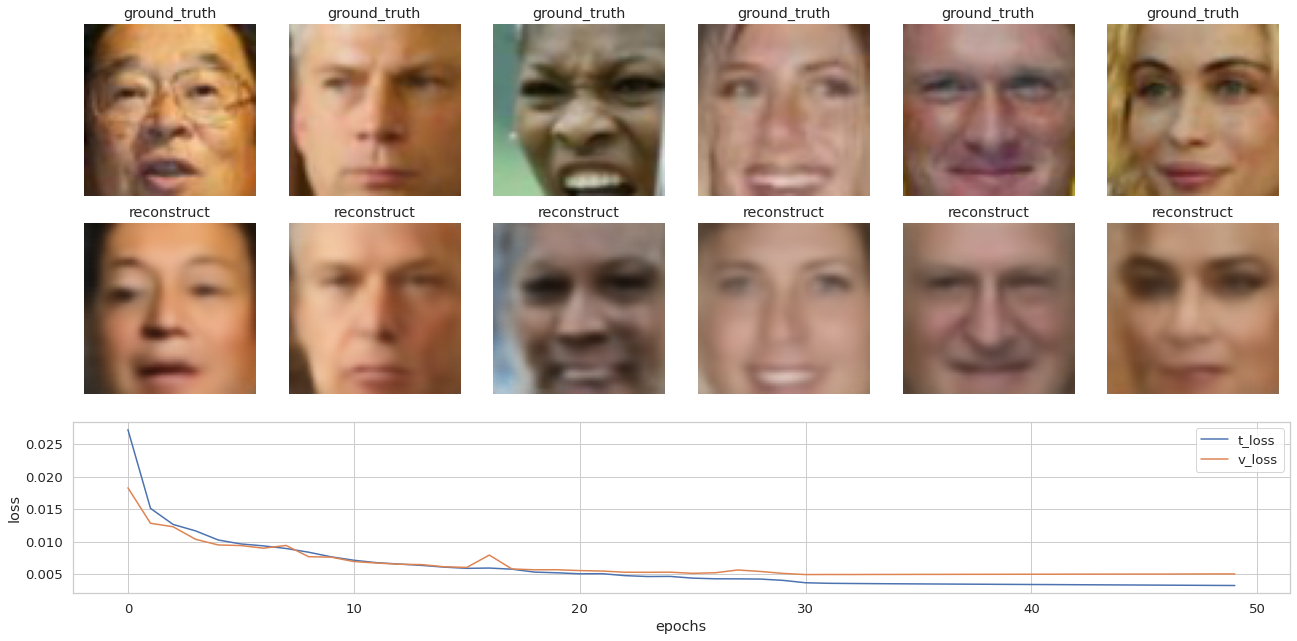

epoch: 100%|██████████| 50/50 [1:30:42<00:00, 108.86s/it]

Training is done! Best epoch 31, best time 3373.0993757247925, best val loss 0.004979107418086932, best train loss 0.0037212475359037966


In [ ]:
epochs = 50
autoencoder = train_model(train_loader, val_loader, autoencoder, 'ae3', epochs, criterion, optimizer, scheduler)

### Посмотрим на результаты обучения автоэнкодера

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
# Загрузим обученный автоэнкодер
autoencoder = Autoencoder().to(DEVICE)
autoencoder.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_ae3.pth')))

<All keys matched successfully>

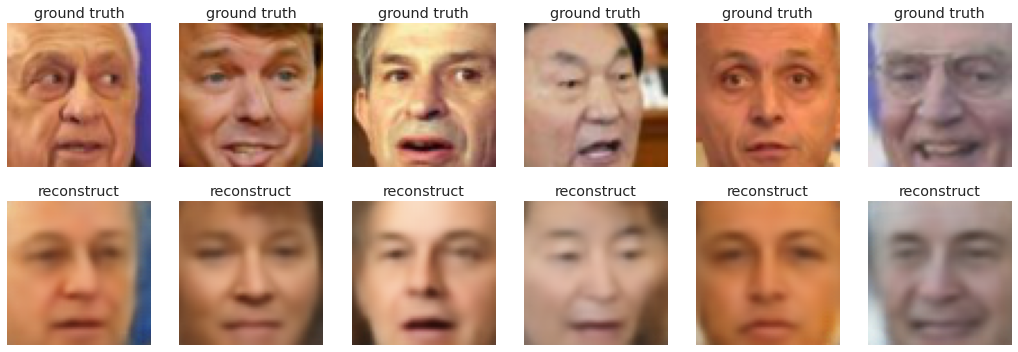

In [ ]:
x_val = next(iter(val_loader))
x_val_np = x_val.detach().numpy()

with torch.no_grad():
    x_reconstr, latent = autoencoder(x_val.to(DEVICE))
    x_reconstr = x_reconstr.cpu().numpy()

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val_np[i+7], 0, 3))
    plt.title('ground truth')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_reconstr[i+7], 0, 3))
    plt.title('reconstruct')

plt.show();

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

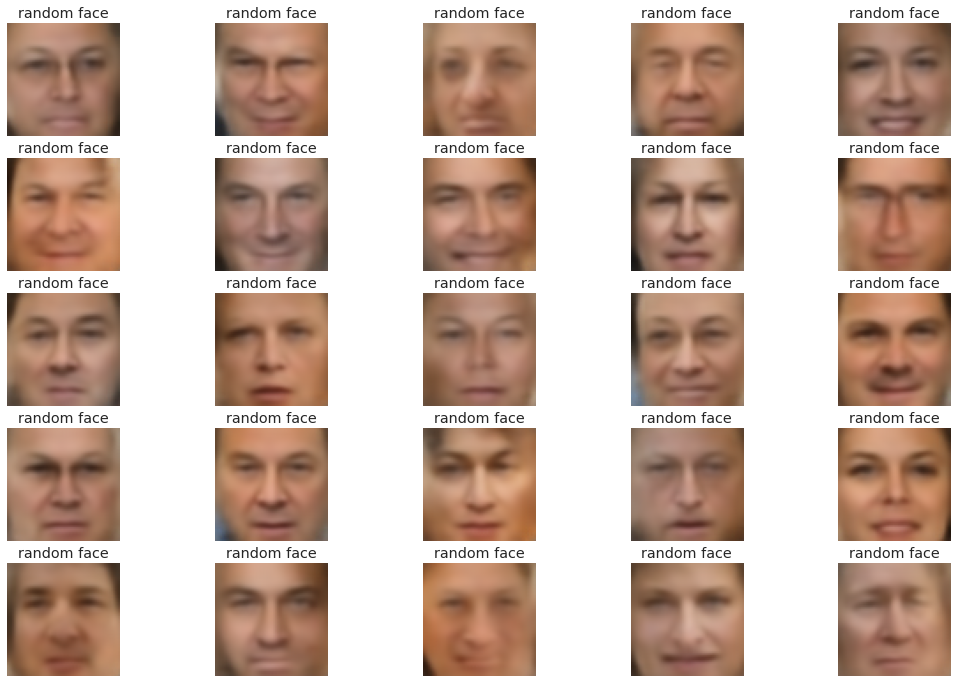

In [ ]:
# Получим 1 батч (128 изображений)
train_batch = next(iter(val_loader))

# Получим 1 латент по батчу
with torch.no_grad():
  train_latent = autoencoder.encoder(train_batch.to(DEVICE)).cpu()

# Посчитаем среднее и стандартное отклонение по каждому элементу латента по батчу
latent_mu = train_latent.mean(0).unsqueeze(0)
latent_std = train_latent.std(0)

# Сгенерируем случайный тензор из нормального распределения, размером 25 х размер латентного вектора
eps = torch.randn(25, latent_std.shape[0])

# Подгоним рандом под распределение латента
samples = latent_mu + (eps * latent_std.unsqueeze(0))

# Получим реконструкцию автоэкнодера
with torch.no_grad():
  output = autoencoder.decoder(samples.to(DEVICE)).cpu().numpy()

# Отрисуем получившиеся изображения
plt.figure(figsize=(18, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(np.clip(output[i], 0, 1), 0, 3))
    plt.title('random face')

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

### Делаем лица радостными

In [ ]:
# Загрузим обученный автоэнкодер
autoencoder = Autoencoder().to(DEVICE)
autoencoder.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_ae3.pth')))

<All keys matched successfully>

In [ ]:
# Найдем индексы не улыбающихся и улыбающихся людей. Выберем по 20 штук.
no_smile = attrs[attrs.Smiling < (-1.8)].head(20).index.to_list()
smile = attrs[attrs.Smiling > 1].head(20).index.to_list()

In [ ]:
# Выберем фотографии не улыбающихся и улыбающихся людей
no_smile_im = data[no_smile]
smile_im = data[smile]

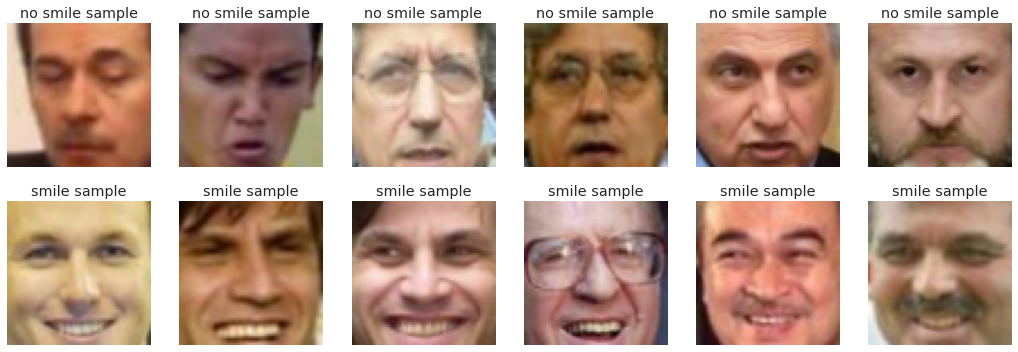

In [ ]:
# Отрисуем несколько фотографий, убедимся, что отбор был сделан верно

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(no_smile_im[i])
    plt.title('no smile sample')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(smile_im[i])
    plt.title('smile sample')


In [ ]:
# Передвинем оси 
x = np.rollaxis(no_smile_im, 3, 1)
y = np.rollaxis(smile_im, 3, 1)

# Получим латентные векторы улыбающихся и неулыбающихся людей
with torch.no_grad():
  latent_no_smile = autoencoder.encoder(torch.from_numpy(x).to(DEVICE)).cpu()
  latent_smile = autoencoder.encoder(torch.from_numpy(y).to(DEVICE)).cpu()

In [ ]:
# Получим средние латентные векторы улыбающихся и неулыбающихся людей
mean_latent_no_smile = latent_no_smile.mean(0)
mean_latent_smile = latent_smile.mean(0)

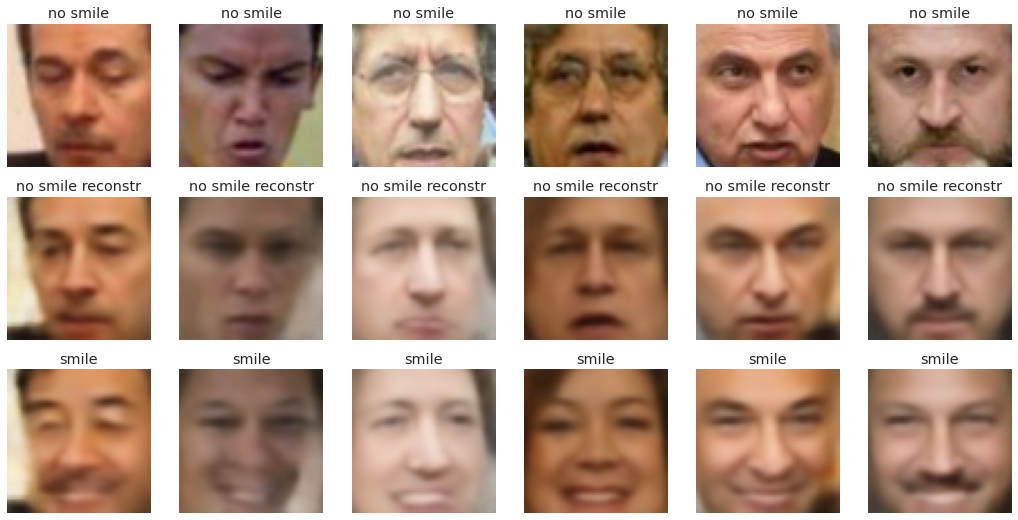

In [ ]:
# Исправим латентные векторы неулыбающихся людей
smile_array = mean_latent_smile - mean_latent_no_smile
latent_no_smile_to_smile = latent_no_smile + smile_array

# Получим реконструкции модели для неулыбающихся людей и для исправленных людей
with torch.no_grad():
  no_smile_to_smile = autoencoder.decoder(latent_no_smile_to_smile.to(DEVICE)).cpu().numpy()
  no_smile_reconstr = autoencoder.decoder(latent_no_smile.to(DEVICE)).cpu().numpy()
  
# Отрисуем результат
plt.figure(figsize=(18, 9))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(no_smile_im[i])
    plt.title('no smile')

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(no_smile_reconstr[i], 0, 3))
    plt.title('no smile reconstr')

    plt.subplot(3, 6, i+13)
    plt.axis("off")
    plt.imshow(np.rollaxis(no_smile_to_smile[i], 0, 3))
    plt.title('smile')

plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

### Надеваем солнечные очки

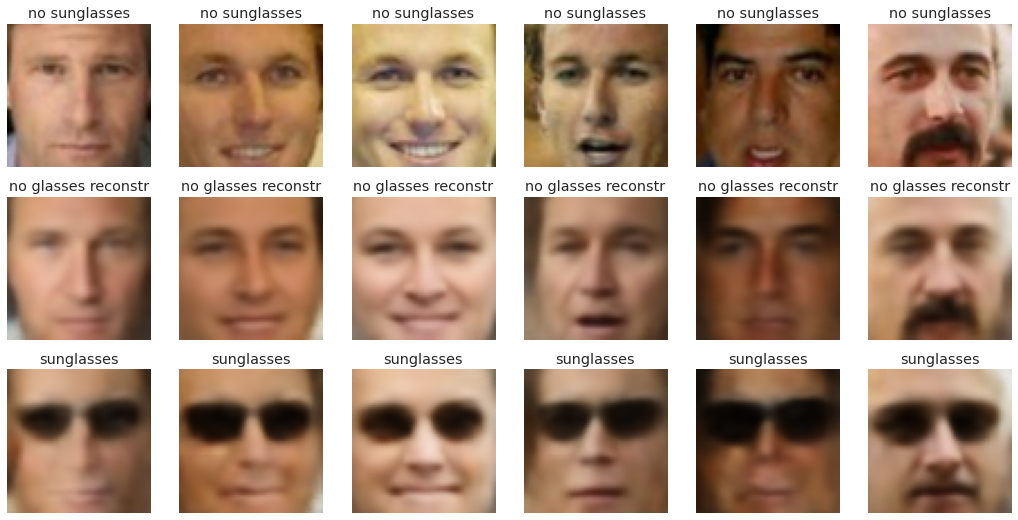

In [ ]:
# Сделаем тоже самое для Sunglasses
no_glasses = attrs[attrs.Sunglasses < (-1.5)].head(15).index.to_list()
glasses = attrs[attrs.Sunglasses > 1.5].head(15).index.to_list()

no_glasses_im = data[no_glasses]
glasses_im = data[glasses]

x = np.rollaxis(no_glasses_im, 3, 1)
y = np.rollaxis(glasses_im, 3, 1)

with torch.no_grad():
  latent_no_glasses = autoencoder.encoder(torch.from_numpy(x).to(DEVICE)).cpu()
  latent_glasses = autoencoder.encoder(torch.from_numpy(y).to(DEVICE)).cpu()

mean_latent_no_glasses = latent_no_glasses.mean(0)
mean_latent_glasses = latent_glasses.mean(0)

glasses_array = mean_latent_glasses - mean_latent_no_glasses
latent_no_glasses_to_glasses = latent_no_glasses + glasses_array

with torch.no_grad():
  with_glasses = autoencoder.decoder(latent_no_glasses_to_glasses.to(DEVICE)).cpu().numpy()
  no_glasses = autoencoder.decoder(latent_no_glasses.to(DEVICE)).cpu().numpy()

plt.figure(figsize=(18, 9))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(no_glasses_im[i])
    plt.title('no sunglasses')

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(no_glasses[i], 0, 3))
    plt.title('no glasses reconstr')

    plt.subplot(3, 6, i+13)
    plt.axis("off")
    plt.imshow(np.rollaxis(with_glasses[i], 0, 3))
    plt.title('sunglasses')

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print(f'Размер обучающего датасета: {len(train_loader.dataset)}, размер тестового датасета: {len(test_loader.dataset)}.')

Размер обучающего датасета: 60000, размер тестового датасета: 10000.


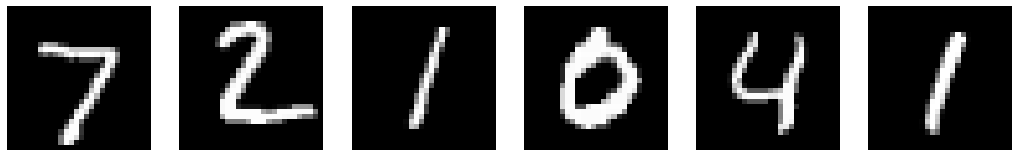

In [ ]:
x_test = next(iter(test_loader))

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(x_test[0][i].squeeze(0).numpy(), cmap='gray')
    # plt.title('no sunglasses')

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
features = 8

class VAE(nn.Module):
    def __init__(self):
        '''<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>'''
        super().__init__()

        self.encoder = nn.Sequential(
            # s1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding = 1, padding_mode='replicate'),
            nn.ReLU(),

            # s2 28 -> 14
            nn.MaxPool2d(2),

            # s3 14 -> 6
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),                       
            
            nn.Flatten(),

            nn.Linear(in_features=6*6*64, out_features=4*64),
            nn.ReLU(),

            nn.Linear(in_features=4*64, out_features=features*2)
          )
        
        self.decoder = nn.Sequential(  
                      
            nn.Linear(in_features=features, out_features=4*64),
            nn.ReLU(),

            nn.Linear(in_features=4*64, out_features=6*6*64),
            nn.ReLU(),

            nn.Unflatten(1, torch.Size([64, 6, 6])),
            
            # s4 6 -> 14
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),

            # s5 14 -> 28
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            # s6
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)             
        )


    def encode(self, x):
        '''<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>'''
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as variance
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            '''<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>'''
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space

        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            sample = mu
        
        return sample
    
    def decode(self, z, eps=1e-7):
        '''<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>'''
        x = self.decoder(z)
        reconstruction = torch.clamp(x.sigmoid(), min=eps, max=1-eps)
                
        return reconstruction    

    def forward(self, x):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [ ]:
import torchsummary
vae = VAE().to(DEVICE)
torchsummary.summary(vae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 6, 6]          65,600
              ReLU-5             [-1, 64, 6, 6]               0
           Flatten-6                 [-1, 2304]               0
            Linear-7                  [-1, 256]         590,080
              ReLU-8                  [-1, 256]               0
            Linear-9                   [-1, 16]           4,112
           Linear-10                  [-1, 256]           2,304
             ReLU-11                  [-1, 256]               0
           Linear-12                 [-1, 2304]         592,128
             ReLU-13                 [-1, 2304]               0
        Unflatten-14             [-1, 6

### Loss для VAE

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:

def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных классов
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    
    return loss / mu.shape[0]

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    batch = x.shape[0]
    x = x.view(-1)
    reconstruction = reconstruction.view(-1)

    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x) / batch

def loss_vae(x, mu, logsigma, reconstruction):
    
    # <соедините тут две компоненты лосса. Mind the sign!>
    
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

### Обучение VAE

И обучим модель:

In [ ]:
criterion = loss_vae

vae = VAE().to(DEVICE)

optimizer = optim.AdamW(params = vae.parameters())

In [ ]:
# <обучите модель на датасете MNIST>

### Функции для обучения VAE

Функции для обучения модели

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    processed_size = 0
      
    for inputs, _ in train_loader:
        inputs = inputs.to(DEVICE)
                
        mu, logsigma, reconstruction  = model(inputs)
        loss = criterion(inputs, mu, logsigma, reconstruction)
                
        loss.backward()
        optimizer.step()
                        
        running_loss += loss.item() * inputs.size(0)             
        processed_size += inputs.size(0)
                
        optimizer.zero_grad()
              
    train_loss = running_loss / processed_size
        
    return train_loss

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    with torch.no_grad():

      for inputs, _ in val_loader:
          inputs = inputs.to(DEVICE)

          mu, logsigma, reconstruction  = model(inputs)
          loss = criterion(inputs, mu, logsigma, reconstruction)

          running_loss += loss.item() * inputs.size(0)
          processed_size += inputs.size(0)
          
    val_loss = running_loss / processed_size
    
    return val_loss

In [ ]:
def plot_reconstr_loss(x_val, x_reconstr, train_losses, val_losses):
  plt.figure(figsize=(18, 9))

  for i in range(6):
      plt.subplot(4, 6, i+1)
      plt.axis("off")
      plt.imshow(x_val[i], cmap='gray')
      plt.title('ground_truth')

      plt.subplot(4, 6, i+7)
      plt.axis("off")
      plt.imshow(x_reconstr[i], cmap='gray')
      plt.title('reconstruct')
  
  plt.subplot(2,1,2)
  plt.plot(train_losses, label="t_loss")
  plt.plot(val_losses, label="v_loss")
  plt.legend(loc='upper right')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  
  # plt.tight_layout()
  plt.show();

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs, criterion, optimizer):
    X_val, _ = next(iter(val_loader))
    
    best_loss = 5000

    since = time()

    dict_losses = {
        'train_loss': [],
        'val_loss': []
        }

    log_template = "\nEpoch {ep:03d}  train_loss: {t_loss:0.4f} \
     val_loss {v_loss:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            set_seed(2147483647 + epoch)
            
            # train and val
            t_loss = fit_epoch(model, train_loader, criterion, optimizer)                    
            v_loss = eval_epoch(model, val_loader, criterion)

            # scheduler.step()

            # save history for graphs
            dict_losses['train_loss'].append(t_loss)      
            dict_losses['val_loss'].append(v_loss)
            
            # save best model
            if best_loss > v_loss:
                best_loss = v_loss
                best_t_loss = t_loss
                torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
                best_epoch = epoch + 1
                best_time = time() - since

            # save current model
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
            
                        
            # show intermediate results
            model.eval()  # testing mode
            with torch.no_grad():
              mu, logsigma, reconstruction = model(X_val.to(DEVICE))
              x_reconsr = reconstruction.detach().cpu().squeeze(1).numpy()
            
            # Visualize tools
            clear_output(wait=True)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=t_loss, v_loss=v_loss))

            plot_reconstr_loss(X_val.squeeze(1).numpy(), x_reconsr, dict_losses['train_loss'], dict_losses['val_loss'])

    print(f'Training is done! Best epoch {best_epoch}, best time {best_time}, best val loss {best_loss}, best train loss {best_t_loss}')               
    
    # загрузим лучшие веса модели
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))
    
    return model

### Обучение VAE

epoch: 100%|██████████| 20/20 [05:33<00:00, 16.70s/it]


Epoch 020  train_loss: 105.3755      val_loss 102.1982


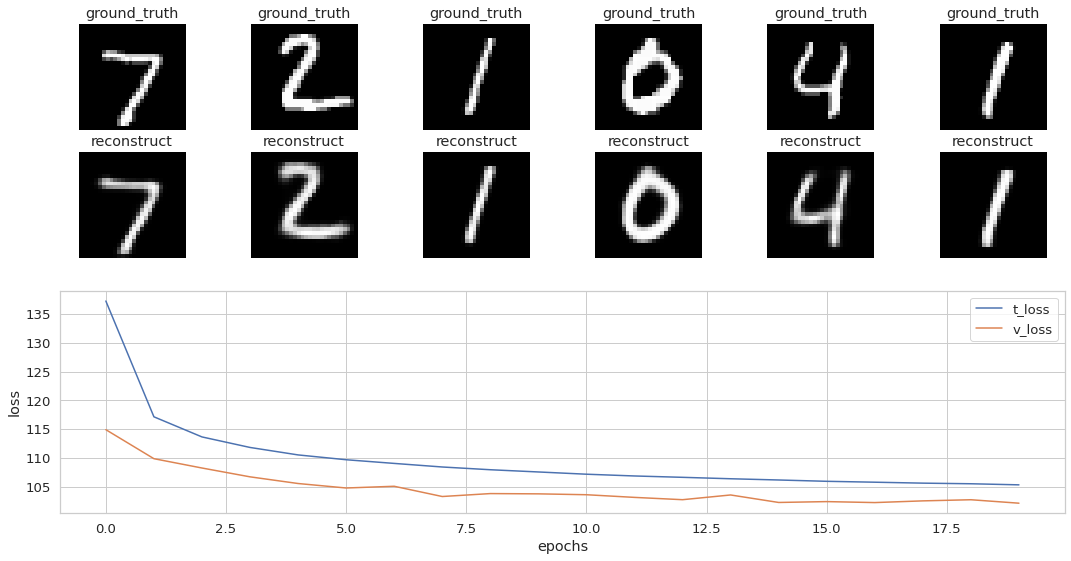

epoch: 100%|██████████| 20/20 [05:35<00:00, 16.75s/it]

Training is done! Best epoch 20, best time 333.38958764076233, best val loss 102.1982161743164, best train loss 105.37551483154297


In [ ]:
epochs = 20
vae = train_model(train_loader, test_loader, vae, 'vae1', epochs, criterion, optimizer)

### Результаты обучения VAE

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

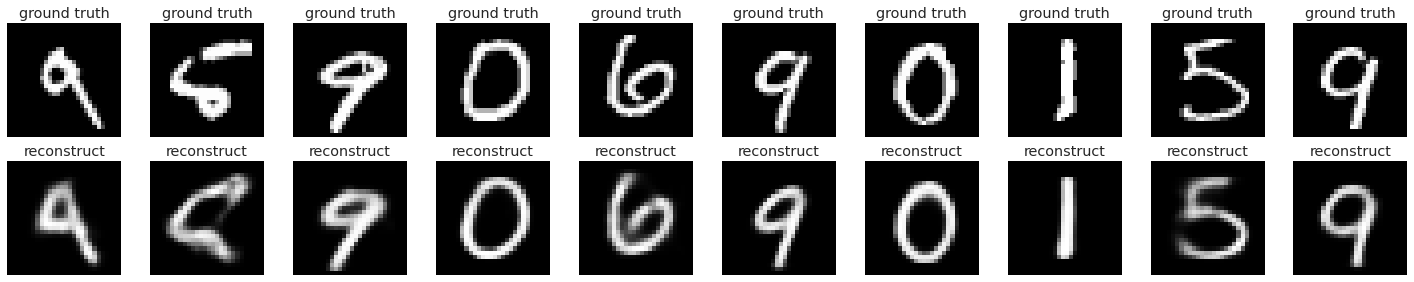

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
x_val, labels = next(iter(test_loader))
x_val_np = x_val.detach().squeeze(1).numpy()

with torch.no_grad():
    vae.eval()
    mu, logsigma, x_reconstr = vae(x_val.to(DEVICE))
    x_reconstr = x_reconstr.cpu().squeeze(1).numpy()

plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.axis("off")
    plt.imshow(x_val_np[i+7], cmap='gray')
    plt.title('ground truth')

    plt.subplot(2, 10, i+11)
    plt.axis("off")
    plt.imshow(x_reconstr[i+7], cmap='gray')
    plt.title('reconstruct')

plt.tight_layout()
plt.show();

### Генерация случайных изображений

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# Загрузим обученный vae
vae = VAE().to(DEVICE)
vae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_vae1.pth')))

<All keys matched successfully>

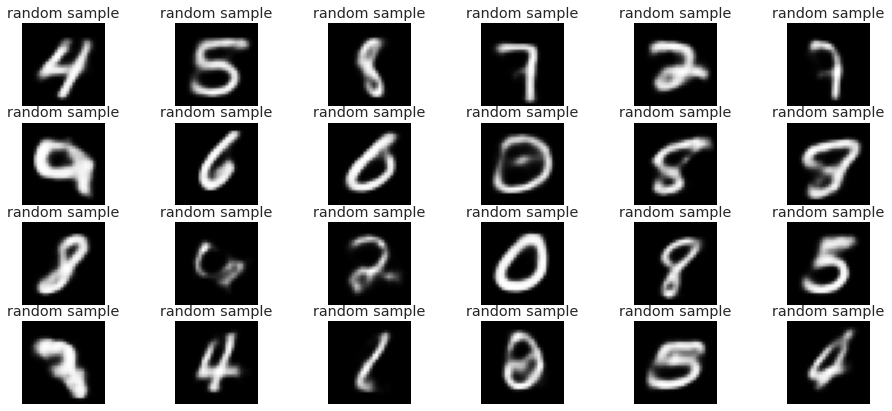

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных

# Вариант без подгонки под распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(24)])
z = torch.FloatTensor(z).to(DEVICE)
with torch.no_grad():
  output = vae.decode(z).cpu().squeeze(1).numpy()

plt.figure(figsize=(16, 7))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.axis("off")
    plt.imshow(output[i], cmap='gray')
    plt.title('random sample')

plt.show();

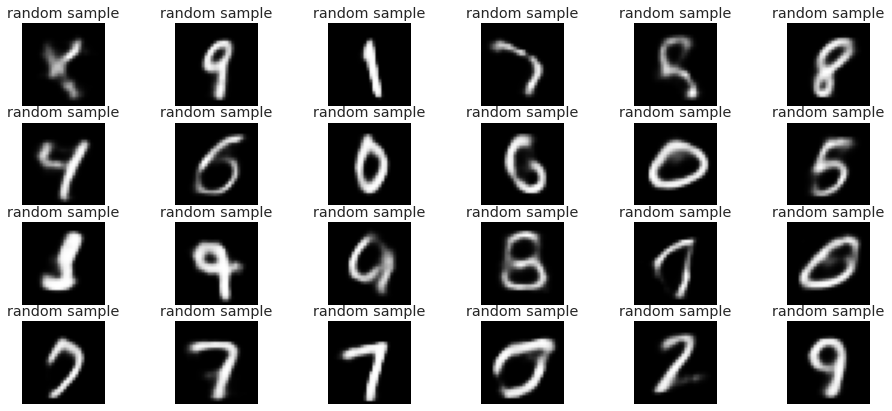

In [ ]:
# Вариант с подгонкой под распределение латентных переменных

# Получим 1 батч (32 изображения)
train_batch, _ = next(iter(test_loader))

# Получим латенты по батчу
with torch.no_grad():
  vae.eval()
  mu, _ = vae.encode(train_batch.to(DEVICE))

# Посчитаем среднее по каждому элементу латента по батчу
latent_mu = mu.cpu().mean(0)

# Сгенерируем случайный тензор из нормального распределения, размером 25 х размер латентного вектора
eps = torch.randn(24, latent_mu.shape[-1])

# Подгоним рандом под распределение латента
samples = latent_mu + eps

with torch.no_grad():
  output = vae.decode(samples.to(DEVICE)).cpu().squeeze(1).numpy()

plt.figure(figsize=(16, 7))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.axis("off")
    plt.imshow(output[i], cmap='gray')
    plt.title('random sample')

plt.show();

**UPD:**\
На мой взгляд, VAE отлично справился с полностью случайным вектором, сгенерированным из нормального распределения.

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
# Загрузим обученный vae
vae = VAE().to(DEVICE)
vae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_vae1.pth')))

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

labels = np.zeros(1)
latents = np.zeros((1,8))

# Получим латентные представления цифр тестового датасета
with torch.no_grad():
  vae.eval()
  for inputs, label in test_loader:
    inputs = inputs.to(DEVICE)
    latent, _ = vae.encode(inputs)
    latents = np.concatenate((latents, latent.cpu().numpy()))
    labels = np.concatenate((labels, label.numpy()))

labels = np.delete(labels, 0, axis=0)
latents = np.delete(latents, 0, axis=0)

print(f'Размеры полученных латентных векторов {latents.shape}. Размеры полученных лейблов латентных векторов {labels.shape}.')

Размеры полученных латентных векторов (10000, 8). Размеры полученных лейблов латентных векторов (10000,).


In [ ]:
# Запишем латентные векторы и их лейблы в файл
dict_latent_vae1 = {
    'latents': latents,
    'labels': labels}

with open(os.path.join(DATA_DIR, 'dict_latent_vae1.pickle'), 'wb') as f:
    pickle.dump(dict_latent_vae1, f)

In [ ]:
# Загрузим латентные векторы и лейблы из словаря
with open(os.path.join(DATA_DIR, 'dict_latent_vae1.pickle'), 'rb') as f:
        dict_latent_vae1 = pickle.load(f)

In [ ]:
# Сожмем латентные векторы
latents = dict_latent_vae1['latents']

latents_tsne = TSNE(n_components=2, random_state=1).fit_transform(latents)
latents_tsne.shape

(10000, 2)

In [ ]:
dict_latent_vae1['latents_tsne'] = latents_tsne
with open(os.path.join(DATA_DIR, 'dict_latent_vae1.pickle'), 'wb') as f:
    pickle.dump(dict_latent_vae1, f)

In [ ]:
# Загрузим латентные векторы и лейблы из словаря
with open(os.path.join(DATA_DIR, 'dict_latent_vae1.pickle'), 'rb') as f:
        dict_latent_vae1 = pickle.load(f)

latents = dict_latent_vae1['latents']
labels = dict_latent_vae1['labels']
latents_tsne = dict_latent_vae1['latents_tsne']

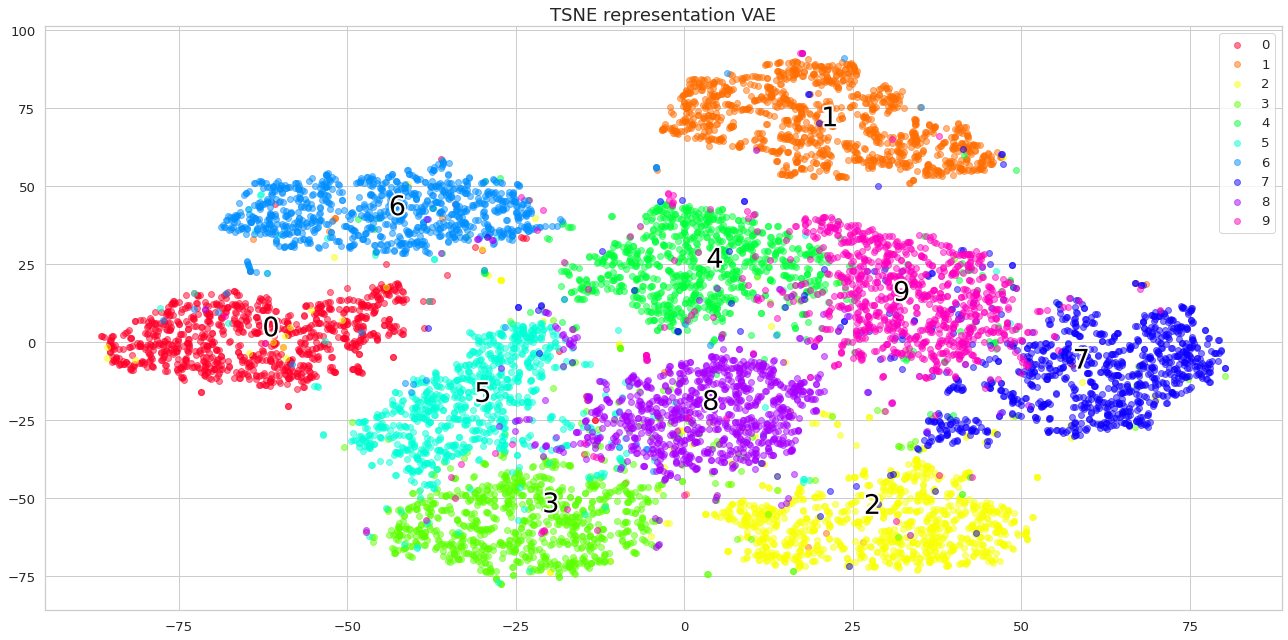

In [ ]:
# отрисуем изображение латентных векторов
from matplotlib import patheffects as path_effects

colors = cm.gist_rainbow(np.linspace(0, 1, len(np.unique(labels))))

plt.figure(figsize=(18, 9))
for label, color in zip(np.unique(labels), colors):
    plt.scatter(latents_tsne[labels== label, 0], 
                latents_tsne[labels== label, 1], 
                c=color.reshape(1,-1), 
                alpha=0.5, 
                label=str(int(label))
                )
    x = np.mean(latents_tsne[labels== label, 0])
    y = np.mean(latents_tsne[labels== label, 1])
    plt.text(x, y, str(int(label)),
             fontsize=27, 
             c='black',
             path_effects=[
                           path_effects.Stroke(linewidth=4, foreground='white'),
                           path_effects.Normal()
                           ], 
             )

plt.title('TSNE representation VAE', fontsize=18)  
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Что вы думаете о виде латентного представления?

Представление получилось не сильно компактным (не так, как в лекции). Но точки, относящиеся к одной цифре расположены в кластерах (облачках), они визуально разделимы. При этом, кластеры с похожими цифрами расположены близко друг к другу.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
# количество классов, размер изображения
features = 8
num_classes = 10

class CVAE(nn.Module):
    def __init__(self):
        '''
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        '''
        super().__init__()
        
        self.flatten = nn.Flatten()
        
        self.encoder = nn.Sequential(
            
            nn.Linear(in_features=(28*28+num_classes), out_features=4*64),
            nn.ReLU(),

            nn.Linear(in_features=4*64, out_features=64),
            nn.ReLU(),

            nn.Linear(in_features=64, out_features=features*2)
          )
        
        self.decoder = nn.Sequential(  
                      
            nn.Linear(in_features=(features+num_classes), out_features=64),
            nn.ReLU(),

            nn.Linear(in_features=64, out_features=4*64),
            nn.ReLU(),

            nn.Linear(in_features=4*64, out_features=28*28)                         
        )

        self.ohe = LabelBinarizer()

    def onehot(self, label, num_classes=num_classes):
      # обучаем кодировщик
      
      # label = label.int() for torchsummary
      lb_classes = self.ohe.fit_transform(np.arange(num_classes).reshape(-1,1))
      lb_class = torch.FloatTensor(lb_classes[label.cpu()]).to(DEVICE)

      return lb_class


    def encode(self, x, label):
        '''
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        '''
        # Первым слоем в энкодере идет свертка. 
        # Сделаем так, чтобы изображение просто увеличилось на 1 строку пикселей.
        # Для этого получим закодированный вектор классов,
        # "приклеим" к нему недостающее количество, и все это "приклеим" к картинке.
        
        lb_class = self.onehot(label)

        x = self.flatten(x)
        x = torch.cat((x, lb_class), dim=-1)
        
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as variance

        return mu, logsigma, label
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            '''<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>'''
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space

        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            sample = mu
        
        return sample
    
    def decode(self, z, label, eps=1e-7):
        '''
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>
        '''
        lb_class = self.onehot(label)
        z = torch.cat((z, lb_class), dim=1)
        z = self.decoder(z)

        reconstruction = torch.clamp(z.sigmoid(), min=eps, max=1-eps).view(-1, 1, 28, 28)
        
        return reconstruction

    def get_latent(self, x, label):
        lb_class = self.onehot(label)
        x = self.flatten(x)
        x = torch.cat((x, lb_class), dim=-1)
        x = self.encoder(x).view(-1, 2, features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
        return z

    def forward(self, x, label):
        '''
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        '''
        mu, logsigma, label = self.encode(x, label)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, label).view(-1, 1, 28, 28)

        return mu, logsigma, reconstruction

### Обучение

Функция обучения. Напишем в этот раз 1 функцию, вместо 4-х.

In [ ]:
def train_model(train_loader, test_loader, model, model_name, epochs, criterion, optimizer):
    # X, L = next(iter(test_loader))

    best_loss = 5000
    since = time()    
    
    # loss per batch
    train_losses = []
    test_losses = []  
            
    for epoch in tqdm(range(epochs)):
        set_seed(2147483647 + epoch)
        
        # train--------------------------
        model.train()
        train_losses_per_epoch = []

        for x_batch, label in train_loader:
          mu, logsigma, reconstruction = model(x_batch.to(DEVICE), label.to(DEVICE))
          loss = criterion(x_batch.to(DEVICE), mu, logsigma, reconstruction)
                
          loss.backward()
          optimizer.step()

          train_losses_per_epoch.append(loss.detach().cpu().item())          

          optimizer.zero_grad()
        
        train_losses.append(np.mean(train_losses_per_epoch))

                      
        # test---------------------------
        model.eval()
        test_losses_per_epoch = []

        with torch.no_grad():
          for x_batch, label in test_loader:
            x_batch = x_batch.to(DEVICE)
            label = label.to(DEVICE)
            mu, logsigma, reconstruction = model(x_batch, label)
            loss = criterion(x_batch, mu, logsigma, reconstruction)

            test_losses_per_epoch.append(loss.detach().cpu().item())            

        test_losses.append(np.mean(test_losses_per_epoch))


        # save best model-------------------------------
        if best_loss > test_losses[-1]:
            best_loss = test_losses[-1]
            best_t_loss = train_losses[-1]
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = time() - since

        # save current model
        torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
        
        # Visualize tools---------------------------------
        clear_output(wait=True)

        plt.figure(figsize=(18, 9))

        for i in range(6):
            plt.subplot(4, 6, i+1)
            plt.axis("off")
            plt.imshow(x_batch.cpu().squeeze(1).numpy()[i], cmap='gray')
            plt.title('ground_truth')

            plt.subplot(4, 6, i+7)
            plt.axis("off")
            plt.imshow(reconstruction.cpu().squeeze(1).numpy()[i], cmap='gray')
            plt.title('reconstruct')
          
        plt.subplot(2,1,2)
        plt.plot(train_losses, label="train_loss")
        plt.plot(test_losses, label="test_loss")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        
        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - test loss: {test_losses[-1]:.4f}',
                     fontsize=18)
        
        plt.show();             

    # final ----------------------------------------------------------
    print(f'Training is done! Best epoch {best_epoch}, best time {best_time}, best test loss {best_loss}, best train loss {best_t_loss}')               
    
    # загрузим лучшие веса модели
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))
    
    return model

### Функция потерь

In [ ]:
# Будем использовать ту же, что для VAE (кросс-энтропия + KL-дивергенция)

def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных классов
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    
    return loss / mu.shape[0]

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    batch = x.shape[0]
    x = x.view(-1)
    reconstruction = reconstruction.view(-1)

    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x) / batch

def loss_cvae(x, mu, logsigma, reconstruction):
    
   return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

### Обучение CVAE

In [ ]:
cvae = CVAE().to(DEVICE)
criterion = loss_cvae
optimizer = optim.AdamW(params = cvae.parameters())

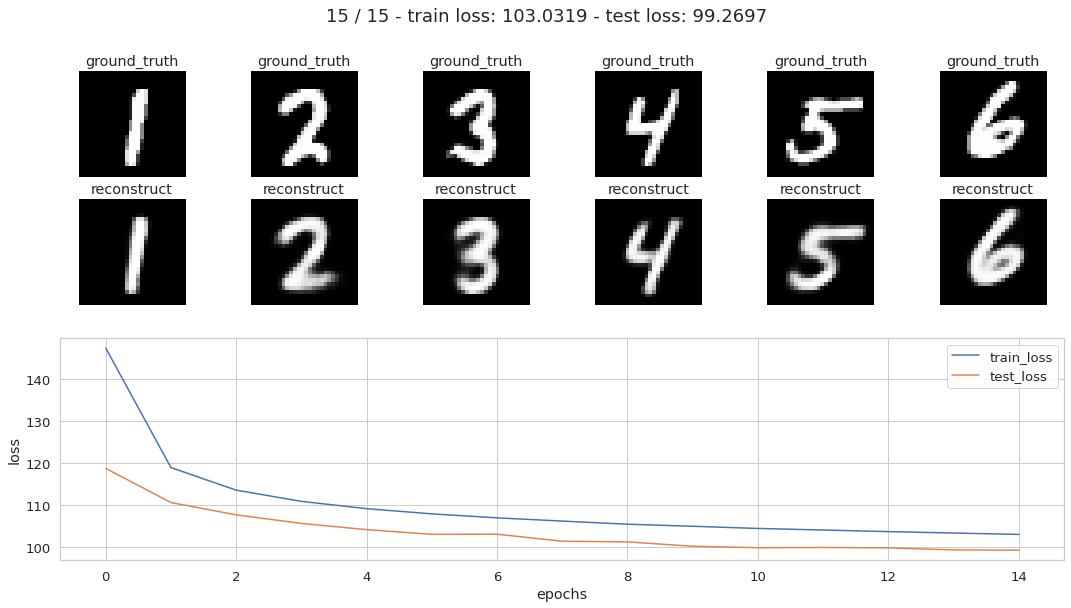

100%|██████████| 15/15 [03:41<00:00, 14.80s/it]

Training is done! Best epoch 15, best time 220.3319067955017, best test loss 99.26971494047025, best train loss 103.03187786865234


In [ ]:
cvae = train_model(train_loader, test_loader, cvae, 'cvae1', 15, criterion, optimizer)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

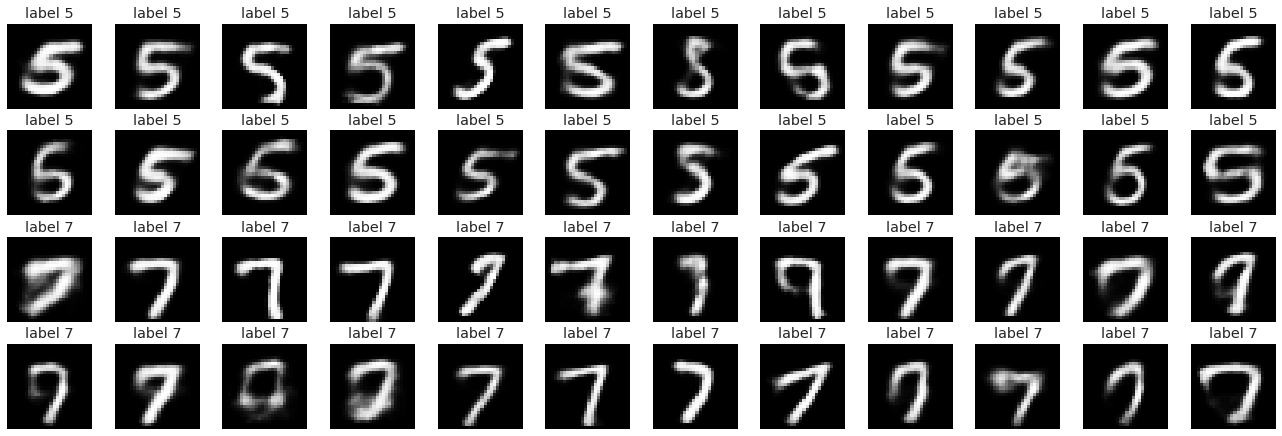

In [ ]:
# Сделаем, как в задании указано - сэмплируем 5 и 7
z = np.array([np.random.normal(0, 1, features) for i in range(24)]).reshape(-1, features)
z = torch.FloatTensor(z).to(DEVICE)

label_5 = np.array([5 for i in range(24)])
label_5 = torch.Tensor(label_5).int().to(DEVICE)
label_7 = np.array([7 for i in range(24)])
label_7 = torch.Tensor(label_7).int().to(DEVICE)

with torch.no_grad():
  output_5 = cvae.decode(z, label_5).cpu().squeeze(1).numpy()
  output_7 = cvae.decode(z, label_7).cpu().squeeze(1).numpy()

plt.figure(figsize=(18, 6))
for i in range(24):
    plt.subplot(4, 12, i+1)
    plt.axis("off")
    plt.imshow(output_5[i], cmap='gray')
    plt.title('label 5')

    plt.subplot(4, 12, i+25)
    plt.axis("off")
    plt.imshow(output_7[i], cmap='gray')
    plt.title('label 7')

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.show();

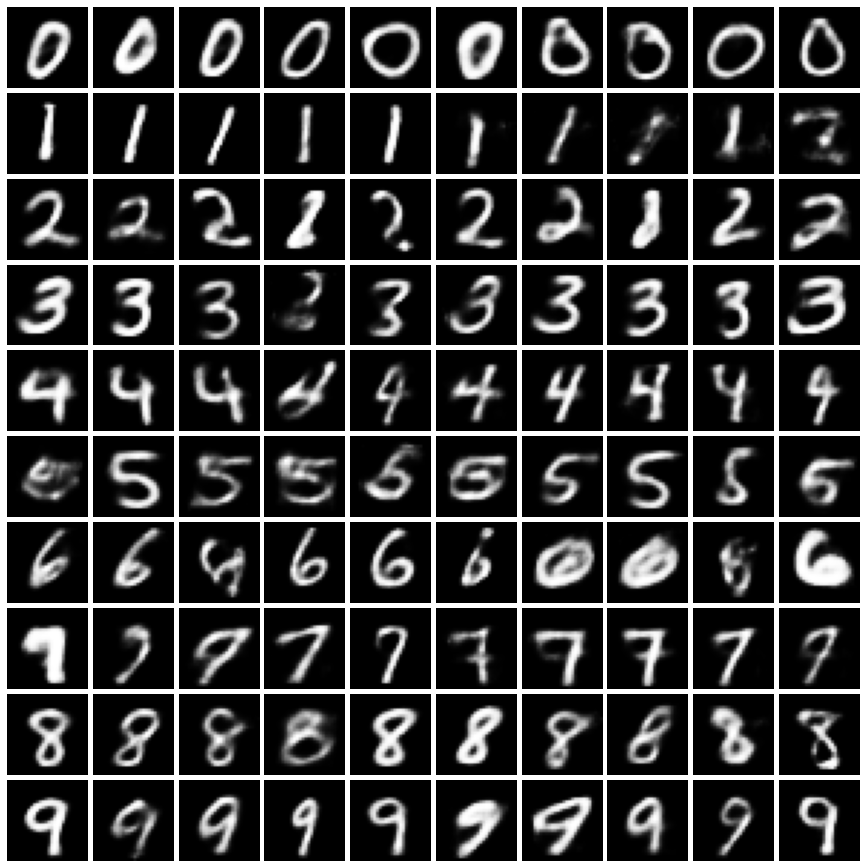

In [ ]:
# Сделаем матрицу 10х10

# 100 векторов из нормального распределения
z = np.array([np.random.normal(0, 1, features) for i in range(100)]).reshape(-1, features)
z = torch.FloatTensor(z).to(DEVICE)

# метки от 0 до 9 (каждая записана по 10 раз)
labels = np.array([j for j in range(10) for i in range(10)])
labels = torch.Tensor(labels).int().to(DEVICE)

# 100 предсказаний
with torch.no_grad():
  output = cvae.decode(z, labels).cpu().squeeze(1).numpy()
  
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    plt.imshow(output[i], cmap='gray')    

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.show();


Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

In [ ]:
# Загрузим обученный vae
cvae = CVAE().to(DEVICE)
cvae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_cvae1.pth')))

In [ ]:
# Получим латенты
labels = np.zeros(1)
latents = np.zeros((1,8))

# Получим латентные представления цифр тестового датасета
with torch.no_grad():
  cvae.eval()
  for inputs, label in test_loader:
    inputs = inputs.to(DEVICE)
    latent = cvae.get_latent(inputs, label.to(DEVICE))
    latents = np.concatenate((latents, latent.cpu().numpy()))
    labels = np.concatenate((labels, label.numpy()))

labels = np.delete(labels, 0, axis=0)
latents = np.delete(latents, 0, axis=0)

# Запишем латентные векторы и их лейблы в файл
dict_latent_cvae1 = {
    'latents': latents,
    'labels': labels}

with open(os.path.join(DATA_DIR, 'dict_latent_cvae1.pickle'), 'wb') as f:
    pickle.dump(dict_latent_cvae1, f)

print(f'Размеры полученных латентных векторов {latents.shape}. Размеры полученных лейблов латентных векторов {labels.shape}.')

Размеры полученных латентных векторов (10000, 8). Размеры полученных лейблов латентных векторов (10000,).


In [ ]:
# Загрузим латентные векторы и лейблы из словаря
with open(os.path.join(DATA_DIR, 'dict_latent_cvae1.pickle'), 'rb') as f:
        dict_latent_cvae1 = pickle.load(f)

# Сожмем латентные векторы
latents = dict_latent_cvae1['latents']
latents_tsne = TSNE(n_components=2, random_state=1).fit_transform(latents)

# запишем сжатые представления латентов
dict_latent_cvae1['latents_tsne'] = latents_tsne
with open(os.path.join(DATA_DIR, 'dict_latent_cvae1.pickle'), 'wb') as f:
    pickle.dump(dict_latent_cvae1, f)

print('Размеры сжатых латентных векторов', latents_tsne.shape)

Размеры сжатых латентных векторов (10000, 2)


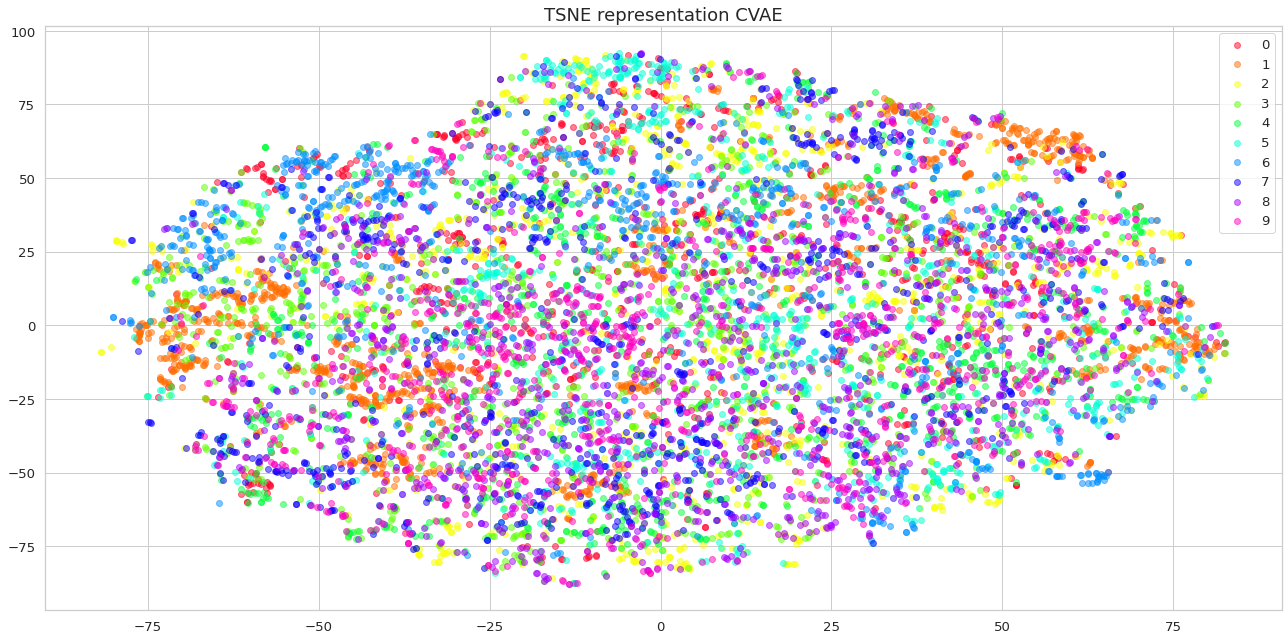

In [ ]:
# Загрузим латентные векторы и лейблы из словаря
with open(os.path.join(DATA_DIR, 'dict_latent_cvae1.pickle'), 'rb') as f:
        dict_latent_cvae1 = pickle.load(f)

latents = dict_latent_cvae1['latents']
labels = dict_latent_cvae1['labels']
latents_tsne = dict_latent_cvae1['latents_tsne']

# отрисуем изображение латентных векторов
colors = cm.gist_rainbow(np.linspace(0, 1, len(np.unique(labels))))

plt.figure(figsize=(18, 9))
for label, color in zip(np.unique(labels), colors):
    plt.scatter(latents_tsne[labels== label, 0], 
                latents_tsne[labels== label, 1], 
                c=color.reshape(1,-1), 
                alpha=0.5, 
                label=str(int(label))
                )    

plt.title('TSNE representation CVAE', fontsize=18)  
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Картинка сильно отличается отличается от картинки для VAE. Никаких отдельных "облачков" для каждого класса, ожидаемо, не выделяется. В среднем латентные векторы для каждой цифры должны быть похожи. Разница только в том, какую именно метку класса мы подаем для восстановления.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
# noise_factor = 0.5
# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

### Загрузка и подготовка данных

In [ ]:
# Загрузим данные
data, attrs = fetch_dataset()

# В качестве тренировки возьмем не весь датасэт, а первые 2000 картинок
data = data[:2000]

# И сразу запишем данные в файл, чтобы не повторять код загрузки полного датасета
with open(os.path.join(DATA_DIR, 'data_fetch_2000.pickle'), 'wb') as f:
    pickle.dump(data, f)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
# Загрузим данные из файла
with open(os.path.join(DATA_DIR, 'data_fetch_2000.pickle'), 'rb') as f:
        data = pickle.load(f)

data.shape

(2000, 64, 64, 3)

In [ ]:
# Сделаем зашумленные образцы
noisy_data = np.copy(data) + 0.3 * np.random.normal(loc=0.0, scale=1.0, size=data.shape).astype('float32')

# Разделим на трейн и вал
X_train, X_val, Y_train, Y_val = train_test_split(noisy_data, 
                                                  data,
                                                  train_size=0.8, 
                                                  shuffle=True, 
                                                  random_state=1
                                                  )

# Сделаем dataloaders (передвинем каналы в начало)
train_loader = DataLoader(list(zip(np.rollaxis(X_train, 3, 1), np.rollaxis(Y_train, 3, 1))), 
                          batch_size=64, 
                          shuffle=True)
val_loader = DataLoader(list(zip(np.rollaxis(X_val, 3, 1), np.rollaxis(Y_val, 3, 1))), 
                          batch_size=64, 
                          shuffle=False)

In [ ]:
print(f'Размер обучающего датасета: {len(train_loader.dataset)}, размер тестового датасета: {len(val_loader.dataset)}.')

Размер обучающего датасета: 1600, размер тестового датасета: 400.


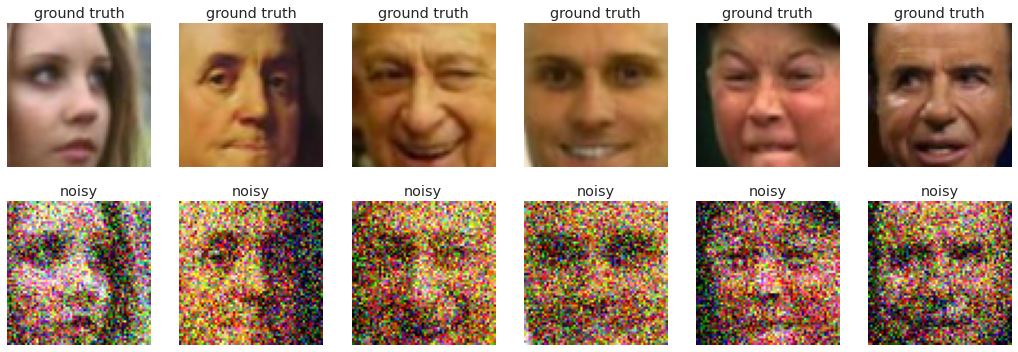

In [ ]:
# Посмотрим, как получилось с зашумлением
x_val, y_val = next(iter(val_loader))
x_val = np.clip(x_val.numpy(), 0, 1)
y_val = np.clip(y_val.numpy(), 0, 1)

   
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(y_val[i+7], 0, 3))
    plt.title('ground truth')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val[i+7], 0, 3))
    plt.title('noisy')

plt.show();

### Архитектура AEden

In [ ]:
# aeden

dim_code = 256

class AEden(nn.Module):
    def __init__(self):
      super().__init__()

      self.encoder = nn.Sequential(
            # s1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding = 1, padding_mode='replicate'),
            nn.ReLU(),
            
            # s2 64 -> 30
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, stride=2, dilation=2, padding = 2, padding_mode='replicate'),
            nn.ReLU(),
            
            # s3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding = 1, padding_mode='replicate'),
            nn.ReLU(),
            
            # s4 30 -> 15
            nn.MaxPool2d(3, stride=2, padding = 1),            
                        
            # s5 15 -> 4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=2, dilation=2),
            nn.ReLU(),                       
            
            nn.Flatten(),

            nn.Linear(in_features=4*4*256, out_features=4*256),
            nn.ReLU(),

            nn.Linear(in_features=4*256, out_features=dim_code)
          )
        
      self.decoder = nn.Sequential(
            
            nn.Linear(in_features=dim_code, out_features=4*256),
            nn.ReLU(),

            nn.Linear(in_features=4*256, out_features=4*4*256),
            nn.ReLU(),

            nn.Unflatten(1, torch.Size([256, 4, 4])),
            
            # s6 4 -> 15
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, dilation=2),
            nn.ReLU(),            

            # s7 15 -> 30
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            # s8
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            # s9 30 -> 64
            nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(), 
                      
            # s10
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()                       
        )
        
    def forward(self, x):
        
        """реализуйте forward проход автоэнкодера
        в качестве возвращаемых переменных -- латентное представление картинки (latent_code) 
        и полученная реконструкция изображения (reconstruction)"""

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction

In [ ]:
from torchsummary import summary
aeden = AEden().to(DEVICE)
summary(aeden, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 64, 30, 30]          25,664
              ReLU-4           [-1, 64, 30, 30]               0
            Conv2d-5          [-1, 128, 30, 30]          73,856
              ReLU-6          [-1, 128, 30, 30]               0
         MaxPool2d-7          [-1, 128, 15, 15]               0
            Conv2d-8            [-1, 256, 4, 4]         819,456
              ReLU-9            [-1, 256, 4, 4]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 256]         262,400
           Linear-14                 [-

### Функция обучения AEden

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs, criterion, optimizer):
    
    best_loss = 5000
    since = time()    
    
    # loss per batch
    train_losses = []
    test_losses = []  
            
    for epoch in tqdm(range(epochs)):
        set_seed(2147483647 + epoch)
        
        # train--------------------------
        model.train()
        train_losses_per_epoch = []

        for x_batch, y_batch in train_loader:
          reconstruction = model(x_batch.float().to(DEVICE))
          loss = criterion(reconstruction, y_batch.float().to(DEVICE))
                
          loss.backward()
          optimizer.step()

          train_losses_per_epoch.append(loss.detach().cpu().item())          

          optimizer.zero_grad()
        
        train_losses.append(np.mean(train_losses_per_epoch))        

                      
        # test---------------------------
        model.eval()
        test_losses_per_epoch = []

        with torch.no_grad():
          for x_batch, y_batch in val_loader:
            reconstruction = model(x_batch.float().to(DEVICE))
            loss = criterion(reconstruction, y_batch.float().to(DEVICE))

            test_losses_per_epoch.append(loss.detach().cpu().item())            

        test_losses.append(np.mean(test_losses_per_epoch))


        # save best model-------------------------------
        if best_loss > test_losses[-1]:
            best_loss = test_losses[-1]
            best_t_loss = train_losses[-1]
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = time() - since

        # save current model
        torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
        
        # Visualize tools---------------------------------
        clear_output(wait=True)

        truth = np.clip(y_batch.cpu().numpy(), 0, 1)
        noisy = np.clip(x_batch.cpu().numpy(), 0, 1)
        reconstuct = np.clip(reconstruction.cpu().numpy(), 0, 1)

        plt.figure(figsize=(18, 9))

        for i in range(6):
            plt.subplot(6, 6, i+1)
            plt.axis("off")
            plt.imshow(np.rollaxis(truth[i], 0, 3))
            plt.title('truth')

            plt.subplot(6, 6, i+7)
            plt.axis("off")
            plt.imshow(np.rollaxis(noisy[i], 0, 3))
            plt.title('noisy')

            plt.subplot(6, 6, i+13)
            plt.axis("off")
            plt.imshow(np.rollaxis(reconstuct[i], 0, 3))
            plt.title('reconstruct')
          
        plt.subplot(2,1,2)
        plt.plot(train_losses, label="train_loss")
        plt.plot(test_losses, label="test_loss")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        
        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - test loss: {test_losses[-1]:.4f}',
                     fontsize=18)
        
        plt.show();             

    # final ----------------------------------------------------------
    print(f'Training is done! Best epoch {best_epoch}, best time {best_time}, best test loss {best_loss}, best train loss {best_t_loss}')               
    
    # загрузим лучшие веса модели
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))
    
    return model

### Обучение AEden

In [ ]:
# Зададим функцию потерь, модель, оптимизатор
criterion = F.mse_loss   # params (input, target)
aeden = AEden().to(DEVICE)
optimizer =  optim.AdamW(params = aeden.parameters())

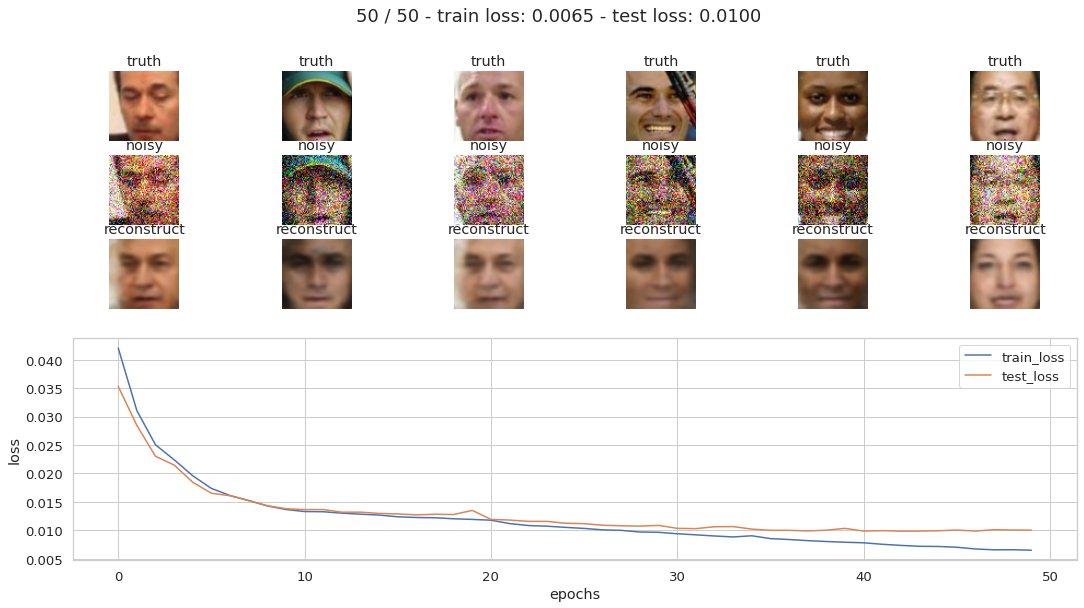

100%|██████████| 50/50 [12:32<00:00, 15.05s/it]

Training is done! Best epoch 43, best time 646.6347379684448, best test loss 0.009833514158214842, best train loss 0.007334072403609753


In [ ]:
aeden = train_model(train_loader, val_loader, aeden, 'aeden', 50, criterion, optimizer)

### Результаты обучения AEden

In [ ]:
# Загрузим обученный автоэнкодер
aeden = AEden().to(DEVICE)
aeden.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_aeden.pth')))

<All keys matched successfully>

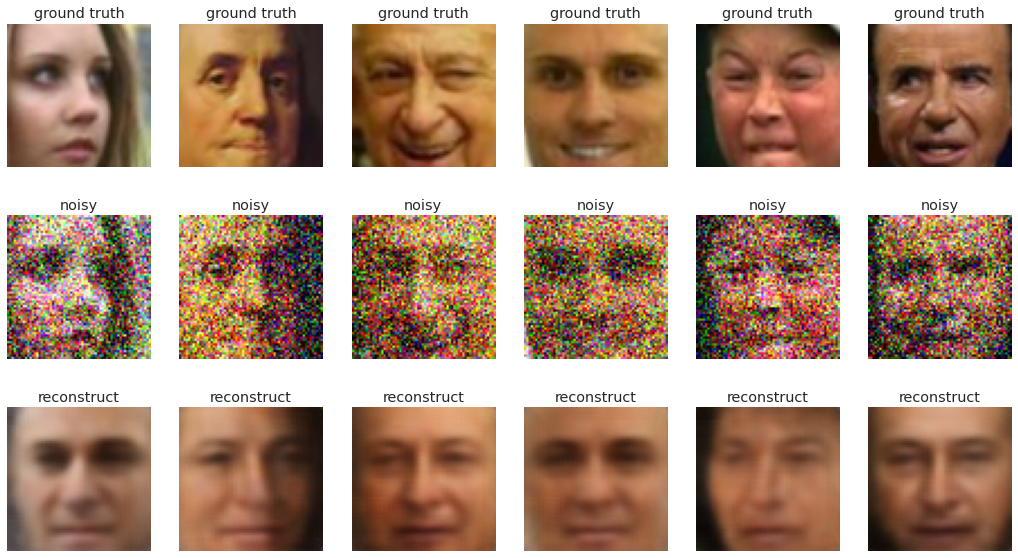

In [ ]:
x_val, y_val = next(iter(val_loader))
y_val = np.clip(y_val.numpy(), 0, 1)

with torch.no_grad():
    x_reconstr = aeden(x_val.float().to(DEVICE)).cpu().numpy()
x_reconstr = np.clip(x_reconstr, 0, 1)
x_val = np.clip(x_val.numpy(), 0, 1)
    
plt.figure(figsize=(18, 10))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(y_val[i+7], 0, 3))
    plt.title('ground truth')

    plt.subplot(3, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val[i+7], 0, 3))
    plt.title('noisy')

    plt.subplot(3, 6, i+13)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_reconstr[i+7], 0, 3))
    plt.title('reconstruct')

plt.show();

Автоэнкодер хорошо справляется с удалением шума на на фото, но плохо с восстановлением лиц (учитывая то, что обучается модель на 1600 снимках без аугментации, а не на полной базе). Я пробовала разные размеры латентного вектора и разную архитектуру и заметила, что увеличение сверточных слоев и увеличение размера латентного вектора в целом приводят к повышению качества восстановленного изображения. В рамках данной задачи необходимо было понять, каким образом научить энкодер удалять шум, поэтому финальная модель небольшая и быстро учится.

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Обученный VAE мы взять не можем, потому что учили его на других параметрах. Напишем новый

### Загрузка и предобработка данных

In [ ]:
# Загрузим данные
data, attrs = fetch_dataset()

# Разделим на трейн и вал
X_train, X_val, atts_train, attrs_val = train_test_split(data,
                                                        attrs,
                                                        train_size=0.8, 
                                                        shuffle=True, 
                                                        random_state=1
                                                        )

In [ ]:
# Сделаем dataloaders (передвинем каналы в начало)
train_loader = DataLoader(np.rollaxis(X_train, 3, 1), 
                          batch_size=256, 
                          shuffle=True,
                          drop_last=True)
val_loader = DataLoader(np.rollaxis(X_val, 3, 1), 
                          batch_size=256, 
                          shuffle=False,
                          drop_last=True)

### Архитектура VAE_fetch

In [ ]:
#vaef2
features = 256

class VAE_fetch(nn.Module):
    def __init__(self):
        '''<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>'''
        super().__init__()

        self.encoder = nn.Sequential(
            # s1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding = 1, padding_mode='replicate'),
            nn.ReLU(),

            # s2 64 -> 32
            nn.MaxPool2d(2),

            # s3 32 -> 16
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),                       
            
            nn.Flatten(),

            nn.Linear(in_features=16*16*64, out_features=16*64),
            nn.ReLU(),

            nn.Linear(in_features=16*64, out_features=features*2)
          )
        
        self.decoder = nn.Sequential(  
                      
            nn.Linear(in_features=features, out_features=16*64),
            nn.ReLU(),

            nn.Linear(in_features=16*64, out_features=16*16*64),
            nn.ReLU(),

            nn.Unflatten(1, torch.Size([64, 16, 16])),
            
            # s4 16 -> 32
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # s5 32 -> 64
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            # s6
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1)             
        )


    def encode(self, x):        
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :] 
        logsigma = x[:, 1, :] 
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std)
            sample = mu + (eps * std) 

        else:            
            sample = mu
        
        return sample
    
    def decode(self, z, eps=1e-7):        
        x = self.decoder(z)
        reconstruction = torch.clamp(x.sigmoid(), min=eps, max=1-eps)
                
        return reconstruction

    def sample(self, z, eps=1e-7):
        generated = self.decoder(z)
        generated = torch.clamp(torch.sigmoid(generated), 0+eps, 1-eps)       
        return generated

    def forward(self, x):        
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [ ]:
import torchsummary
vaef = VAE_fetch().to(DEVICE)
torchsummary.summary(vaef, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          32,832
              ReLU-5           [-1, 64, 16, 16]               0
           Flatten-6                [-1, 16384]               0
            Linear-7                 [-1, 1024]      16,778,240
              ReLU-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
           Linear-10                 [-1, 1024]         263,168
             ReLU-11                 [-1, 1024]               0
           Linear-12                [-1, 16384]      16,793,600
             ReLU-13                [-1, 16384]               0
        Unflatten-14           [-1, 64,

### Loss и функция обучения

In [ ]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())    
    return loss / mu.shape[0]

def log_likelihood(x, reconstruction):    
    batch = x.shape[0]
    x = x.view(-1)
    reconstruction = reconstruction.view(-1)
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x) / batch

def loss_vae(x, mu, logsigma, reconstruction):    
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs, criterion, optimizer, scheduler):
    
    best_loss = 10000
    since = time()    
    
    # loss per batch
    train_losses = []
    test_losses = []  
            
    for epoch in tqdm(range(epochs)):
        set_seed(2147483647 + epoch)
        
        # train--------------------------
        model.train()
        train_losses_per_epoch = []

        for x_batch in train_loader:
          x_batch = x_batch.to(DEVICE)
          mu, logsigma, reconstruction = model(x_batch)
          loss = criterion(x_batch, mu, logsigma, reconstruction)
                
          loss.backward()
          optimizer.step()

          train_losses_per_epoch.append(loss.detach().cpu().item())          

          optimizer.zero_grad()
        
        train_losses.append(np.mean(train_losses_per_epoch)) 

        scheduler.step()
                      
        # test---------------------------
        model.eval()
        test_losses_per_epoch = []

        with torch.no_grad():
          for x_batch in val_loader:
            x_batch = x_batch.to(DEVICE)
            mu, logsigma, reconstruction = model(x_batch)
            loss = criterion(x_batch, mu, logsigma, reconstruction)

            test_losses_per_epoch.append(loss.detach().cpu().item())            

        test_losses.append(np.mean(test_losses_per_epoch))


        # save best model-------------------------------
        if best_loss > test_losses[-1]:
            best_loss = test_losses[-1].round(2)
            best_t_loss = train_losses[-1].round(2)
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = round(time() - since)

        # save current model
        torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
        
        # Visualize tools---------------------------------
        clear_output(wait=True)

        truth = x_batch.cpu().numpy()
        reconstuct = reconstruction.cpu().numpy()
        
        plt.figure(figsize=(18, 9))

        for i in range(6):
            plt.subplot(4, 6, i+1)
            plt.axis("off")
            plt.imshow(np.rollaxis(truth[i], 0, 3))
            plt.title('truth')

            plt.subplot(4, 6, i+7)
            plt.axis("off")
            plt.imshow(np.rollaxis(reconstuct[i], 0, 3))
            plt.title('reconstruct')
          
        plt.subplot(2,1,2)
        plt.plot(train_losses, label="train_loss")
        plt.plot(test_losses, label="val_loss")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        
        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - val loss: {test_losses[-1]:.4f}',
                     fontsize=18)
        
        plt.show();             

    # final ----------------------------------------------------------
    print(f'Training is done! Best epoch {best_epoch}, best time {best_time}, best val loss {best_loss}, best train loss {best_t_loss}')               
    
    # загрузим лучшие веса модели
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))
    
    return model

### Обучение VAE_fetch

In [ ]:
# Зададим функцию потерь, модель, оптимизатор
criterion = loss_vae   
vaef = VAE_fetch().to(DEVICE)
optimizer =  optim.AdamW(params = vaef.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

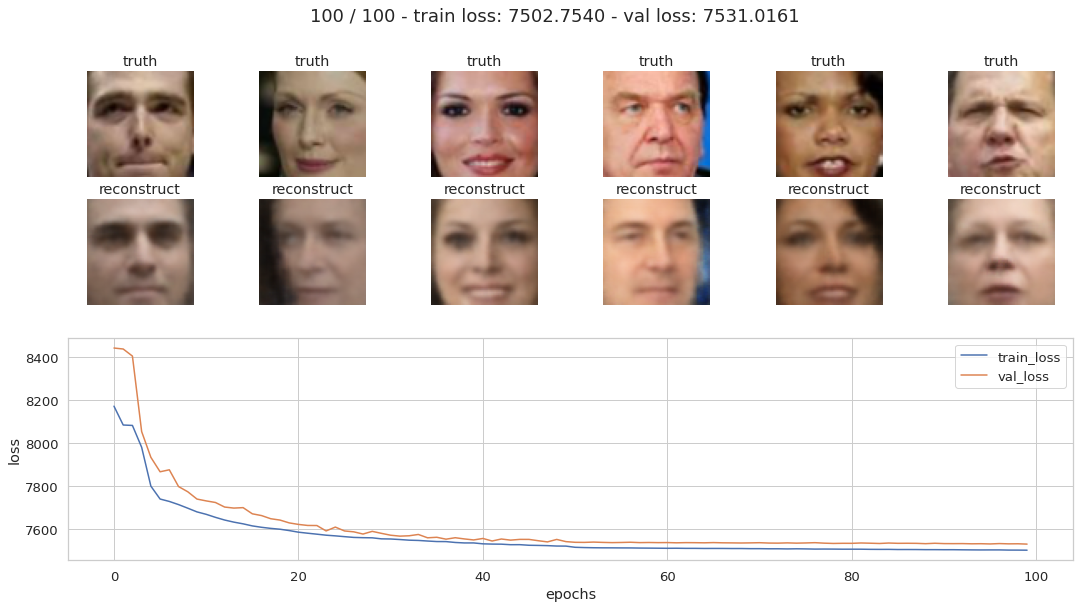

100%|██████████| 100/100 [10:02<00:00,  6.02s/it]


Training is done! Best epoch 100, best time 599, best val loss 7531.02, best train loss 7502.75


In [ ]:
vaef = train_model(train_loader, val_loader, vaef, 'vaef2', 100, criterion, optimizer, scheduler)

### Обучение NearestNighbors

In [ ]:
# Загрузим VAE_fetch, обученный на лицах
vaef = VAE_fetch().to(DEVICE)
vaef.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_vaef2.pth')))

<All keys matched successfully>

LSHForest более не поддерживается. После некоторого изучения документации [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors) я выбрала класс [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors). Его и будем пробовать применять.\
Чтобы потом найти по индексам ближайших соседей, нужно сделать новый Dataloader без перемешивания и с сохранением последнего некомплектного батча. И поставим батч побольше, т.к. обучение и расчет градиентов уже не требуется.

In [ ]:
t_loader = DataLoader(np.rollaxis(X_train, 3, 1), 
                          batch_size=400, 
                          shuffle=False,
                          drop_last=False)

# Получим латентные представления всех лиц тренировочного датасета

codes = np.zeros((1,features))

with torch.no_grad():
  vaef.eval()
  for inputs in train_loader:
    inputs = inputs.to(DEVICE)
    latent, _ = vaef.encode(inputs)
    codes = np.concatenate((codes, latent.cpu().numpy()))
    
codes = np.delete(codes, 0, axis=0)

print(f'Размеры полученных латентных векторов {codes.shape}.')

# Сохраним codes
with open(os.path.join(DATA_DIR, 'codes_latent.pickle'), 'wb') as f:
    pickle.dump(codes, f)

Размеры полученных латентных векторов (10496, 256).


In [ ]:
# обучим NearestNeighbors и сохраним результаты

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5, radius=1, leaf_size=5).fit(codes)

with open(os.path.join(DATA_DIR, 'neighbors_vaef2.pickle'), 'wb') as f:
    pickle.dump(neigh, f)

### Результаты поиска похожих изображений

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей  

  t_image = torch.FloatTensor(np.rollaxis(image[np.newaxis], 3, 1)).to(DEVICE)
  vaef.eval()
  with torch.no_grad():
    code, _ = vaef.encode(t_image)

  (distances,),(idx,) = neigh.kneighbors(code.cpu().numpy(), n_neighbors=n_neighbors)

  t_codes = torch.cuda.FloatTensor(codes[idx])

  vaef.eval()
  with torch.no_grad():
    reconst = vaef.decode(t_codes)

  return distances, reconst.cpu().numpy()

In [ ]:
def show_similar(image, n_neighbors=5):
  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances, neighbors = get_similar(image,n_neighbors=n_neighbors)
    
    plt.figure(figsize=[18,6])
    plt.subplot(2, np.ceil(n_neighbors/2), 1)
    plt.axis("off")
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(n_neighbors):
        plt.subplot(2, np.ceil(n_neighbors/2), i+2)
        plt.axis("off")
        plt.imshow(neighbors[i].transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])

    plt.show()

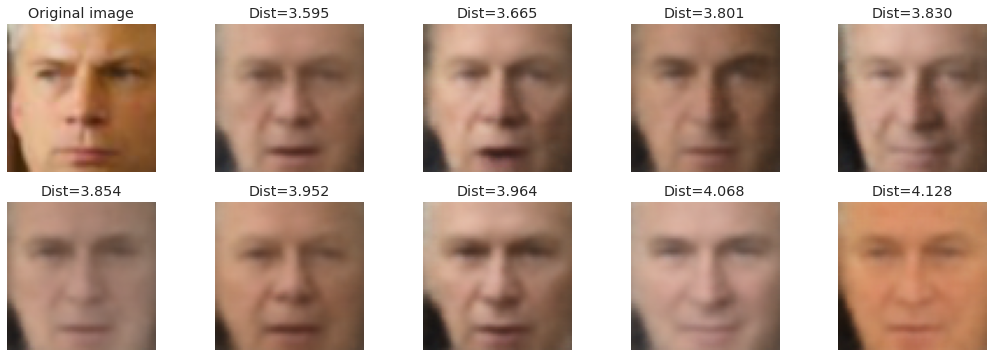

In [ ]:
show_similar(X_val[1], n_neighbors=9)